# Pump it Up: Data Mining the Water Table

### Can you predict which water pumps are faulty?
Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

Competition:
https://www.drivendata.org/competitions/7/

TODO:
- make sure new categories of the test set (not present in the train set) belong to 'Others'
- new column: well age
- new column: funder == installer? (check if this has an effect on status_group)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns

import sklearn as sk
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import xgboost as xgb

In [2]:
# Download the data and load with pandas
TRAIN_DATA_URL = 'https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv'
TRAIN_LABELS_URL = 'https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv'
TEST_DATA_URL = 'https://s3.amazonaws.com/drivendata/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv'

train_values = pd.read_csv(TRAIN_DATA_URL,
                    index_col='id')
train_labels = pd.read_csv(TRAIN_LABELS_URL,
                     index_col='id')
test = pd.read_csv(TEST_DATA_URL,
                   index_col='id')

In [3]:
# merge training values and labels
train = pd.merge(train_values, train_labels, left_index=True, right_index=True)

def status_group_mapper(status_group: str):
    if status_group == 'functional':
        return 2
    elif status_group == 'non functional':
        return 0
    else:
        return 1

# map status_group label to numeric class (0: non-func, 1: repair, 2: func)
train['status_group'] = train['status_group'].apply(status_group_mapper)
train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2


In [4]:
# all train object-columns to lower-case
for cname in train.columns:
    if train[cname].dtype == object:
        train[cname] = train[cname].str.lower()

In [5]:
# all test object-columns to lower-case
for cname in test.columns:
    if test[cname].dtype == object:
        test[cname] = test[cname].str.lower()

### Explore the dataset

- amount_tsh - Total static head (amount water available to waterpoint)
- date_recorded - The date the row was entered
- funder - Who funded the well
- gps_height - Altitude of the well
- installer - Organization that installed the well
- longitude - GPS coordinate
- latitude - GPS coordinate
- wpt_name - Name of the waterpoint if there is one
- num_private -
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- region_code - Geographic location (coded)
- district_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint

In [ ]:
def matrix_plot(cols):
    sns.set(style='whitegrid',context='notebook')
    sns.pairplot(train[cols],size=2.5)
    plt.show()
    
matrix_plot(['amount_tsh','num_private','population','status_group'])

In [ ]:
matrix_plot(['gps_height','latitude', 'longitude','status_group'])

In [6]:
# check for missing values
train.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting           59400
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                   59400
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [7]:
def check_redundant(col1, col2):
    result = np.where(train[col1] != train[col2])[0]
    print('{} != {}: {}/{}'.format(col1, col2, result.size, len(train)))

# check redundancies
check_redundant('quantity', 'quantity_group')
check_redundant('waterpoint_type', 'waterpoint_type_group')
check_redundant('water_quality', 'quality_group')
check_redundant('management', 'management_group')
check_redundant('payment', 'payment_type')
check_redundant('source', 'source_type')
check_redundant('source', 'source_class')
check_redundant('extraction_type', 'extraction_type_group')
check_redundant('extraction_type', 'extraction_type_class')
check_redundant('funder', 'installer')

quantity != quantity_group: 0/59400
waterpoint_type != waterpoint_type_group: 6103/59400
water_quality != quality_group: 51664/59400
management != management_group: 56227/59400
payment != payment_type: 24841/59400
source != source_type: 22392/59400
source != source_class: 59334/59400
extraction_type != extraction_type_group: 2469/59400
extraction_type != extraction_type_class: 21426/59400
funder != installer: 40470/59400


### Data preparation

#### quantity, quantity_group

In [8]:
# TODO remove or merge redundant columns
train = train.drop(columns=['quantity_group'])
test = test.drop(columns=['quantity_group'])

#### population

In [9]:
# replace 0 (zero) in columns with NAs
#train = train.replace({'population':0}, np.nan)
# TODO: binning? p<100, 100<p<500, 500<p<1000, 1000<p

#### funder, installer

In [10]:
# replace 0 (zero) in columns with NAs
train = train.drop(columns=['funder'])
train = train.replace({'installer':'0'}, 'other')
train = train.replace({'installer': np.nan}, 'other') # other or unknown?

test = test.drop(columns=['funder'])
test = test.replace({'installer':'0'}, 'other')
test = test.replace({'installer': np.nan}, 'other') # other or unknown?

In [11]:
def replace_mapper(value: str, contains: str, label: str):
    if contains in value:
        return label
    return value

train['installer'] = train['installer'].apply(lambda v : replace_mapper(v, 'gov', 'government'))
train['installer'] = train['installer'].apply(lambda v : replace_mapper(v, 'comm', 'community'))
train['installer'] = train['installer'].apply(lambda v : replace_mapper(v, 'danid', 'danida'))

test['installer'] = test['installer'].apply(lambda v : replace_mapper(v, 'gov', 'government'))
test['installer'] = test['installer'].apply(lambda v : replace_mapper(v, 'comm', 'community'))
test['installer'] = test['installer'].apply(lambda v : replace_mapper(v, 'danid', 'danida'))

In [12]:
installer = train['installer'].value_counts()
installer_few = train['installer'].isin(installer.index[installer < 100])
train.loc[installer_few, 'installer'] = 'other'
train['installer'].value_counts()

dwe                              17405
other                            15880
government                        3753
community                         1974
danida                            1676
hesawa                            1395
rwe                               1206
district council                   961
kkkt                               910
tcrs                               707
world vision                       699
ces                                610
amref                              443
lga                                413
tasaf                              411
wedeco                             398
fini water                         389
dmdd                               376
norad                              360
twesa                              316
da                                 308
wu                                 301
acra                               278
sema                               249
dw                                 246
jaica                    

In [13]:
installer_values = train['installer'].unique()

test['installer'] = test['installer'].apply(lambda v: 'other' if v not in installer_values else v)

#### waterpoint, waterpoint_type_group

In [14]:
print(train['waterpoint_type'].value_counts(dropna=False))
print(train['waterpoint_type_group'].value_counts(dropna=False))

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64


In [15]:
# make dam (only 7 instances) to others, and drop waterpoint_type_group
train = train.replace({'waterpoint_type':'dam'}, 'other')
train = train.drop(columns=['waterpoint_type_group'])

test = test.replace({'waterpoint_type':'dam'}, 'other')
test = test.drop(columns=['waterpoint_type_group'])

#### construction_year, date_recorded, well_age

In [16]:
# trim the record date to the year
train['date_recorded'] = train['date_recorded'].apply(lambda v : float(v[:4]))
test['date_recorded'] = test['date_recorded'].apply(lambda v : float(v[:4]))

# fill construction_year==0 with the min value (I expect that the year is unknown because it's a while ago)
train = train.replace({'construction_year':0}, np.nan)
test = test.replace({'construction_year':0}, np.nan)
min_construction_year = int(train['construction_year'].min())
train = train.replace({'construction_year':np.nan}, min_construction_year)
test = test.replace({'construction_year':np.nan}, min_construction_year)

# create a new column 'well_age'
train['well_age'] = train['date_recorded'] - train['construction_year']
test['well_age'] = test['date_recorded'] - test['construction_year']

#### extraction_type, extraction_type_group, extraction_type_class

In [17]:
# we only keep extraction_type_class, since all are quite similar and this one has the most understandable groups
train = train.drop(columns=['extraction_type', 'extraction_type_group'])
test = test.drop(columns=['extraction_type', 'extraction_type_group'])
train['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

#### latitude, longitude, gps_height
- there are many zero (0 or -2e-8) which is not withing Tanzania (lat: (-11, -1), lng: (30, 40))
- height extremes in Tanzania are 0 to 5,895m. Minus values might be underground. Many empty 0 values.
- use basin to estimate the apprx. location

In [18]:
# ensure all unknown values are zero (0):
train = train.replace({'latitude':-2.000000e-08}, 0)
test = test.replace({'latitude':-2.000000e-08}, 0)

# bounds of min/max latitude/longitude/height for Tanzania using basin
train_bound = train[(train['latitude']!=0)&(train['longitude']!=0)&(train['gps_height']!=0)]
train_median_geo = train_bound.groupby(['basin',])['latitude','longitude','gps_height'].median()
train_median_geo

,latitude,longitude,gps_height
basin,,,
internal,-4.268302,35.367111,1504
lake nyasa,-9.796345,34.708831,1646
lake rukwa,-7.628407,31.368940,1504
lake tanganyika,-4.639630,30.329597,1286
lake victoria,-1.851610,34.063530,1286
pangani,-3.440594,37.491983,1193
rufiji,-8.456492,35.774562,1235
ruvuma / southern coast,-10.627406,38.934973,343
wami / ruvu,-6.797943,38.360608,174


In [19]:
train.loc[train['gps_height']==0, 'gps_height'] = train['basin'].apply(lambda x : train_median_geo.at[x,'gps_height'])
train.loc[train['longitude']==0, 'longitude'] = train['basin'].apply(lambda x : train_median_geo.at[x,'longitude'])
train.loc[train['latitude']==0, 'latitude'] = train['basin'].apply(lambda x : train_median_geo.at[x,'latitude'])

test.loc[test['gps_height']==0, 'gps_height'] = test['basin'].apply(lambda x : train_median_geo.at[x,'gps_height'])
test.loc[test['longitude']==0, 'longitude'] = test['basin'].apply(lambda x : train_median_geo.at[x,'longitude'])
test.loc[test['latitude']==0, 'latitude'] = test['basin'].apply(lambda x : train_median_geo.at[x,'latitude'])

#### amount_tsh

In [ ]:
train['amount_tsh'].value_counts()

#### others

In [ ]:
train.head()

## Attributes that we are interested in

In [ ]:
train.info()

In [20]:
numeric_cols = ['gps_height', 'latitude', 'longitude', 'well_age']
ordered_cat_cols = []
unordered_cat_cols = ['quantity', 'installer', 'waterpoint_type', 'extraction_type_class']
all_cols = numeric_cols + ordered_cat_cols + unordered_cat_cols

## Encode categorical attributes
- LabelEncoder (ordered)
- LabelBinarizer (unordered)

In [ ]:
def encode_categories(column: pd.core.series.Series):
    encoder = LabelBinarizer()
    return encoder.fit_transform(column)

In [ ]:
for column_name in unordered_cat_cols:
    #train[column_name] = encode_categories(train[column_name])

In [ ]:
encode_categories(train['quantity'])

In [ ]:
train['quantity']

In [21]:
training = pd.get_dummies(train[all_cols], columns=unordered_cat_cols)
training

,gps_height,latitude,longitude,well_age,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,installer_acra,...,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered
id,,,,,,,,,,,,,,,,,,,,,
69572,1390,-9.856322,34.938093,12.0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8776,1399,-2.147466,34.698766,3.0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
34310,686,-3.821329,37.460664,4.0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
67743,263,-11.155298,38.486161,27.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
19728,1286,-1.825359,31.130847,51.0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
9944,1193,-4.765587,39.172796,2.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
19816,1504,-3.766365,33.362410,52.0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
54551,1286,-4.226198,32.620617,52.0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
53934,1286,-5.146712,32.711100,52.0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0


In [22]:
testing = pd.get_dummies(test[all_cols], columns=unordered_cat_cols)
testing

,gps_height,latitude,longitude,well_age,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,installer_acra,...,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered
id,,,,,,,,,,,,,,,,,,,,,
50785,1996,-4.059696,35.290799,1.0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
51630,1569,-3.309214,36.656709,13.0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
17168,1567,-5.004344,34.767863,3.0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
45559,267,-9.418672,38.058046,26.0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
49871,1260,-10.950412,35.006123,13.0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
52449,1685,-3.302420,36.685279,23.0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
24806,550,-7.541382,36.398041,4.0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
28965,234,-10.893786,39.607420,31.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
36301,584,-10.823588,39.262951,16.0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
training.columns

In [ ]:
testing.columns

In [23]:
train_data = training.as_matrix()
train_labels = train['status_group'].as_matrix()
test_data = testing.as_matrix()

## Model selection

In [118]:
#X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=0)
X_train, y_train = (train_data, train_labels)

#### Random Forest

In [25]:
np.random.seed(42)
model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

#### XGBoost

In [119]:
np.random.seed(42)
model = xgb.XGBClassifier(max_depth=16, n_estimators=300, learning_rate=0.1, reg_alpha=0, reg_lambda=1.0)
model = model.fit(X_train, y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([4294.,    0.,    0.,    0.,    0.,  722.,    0.,    0.,    0.,
        6864.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

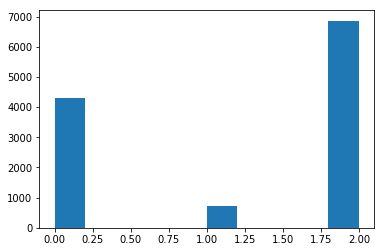

In [120]:
pred_test = model.predict(X_test)
plt.hist(pred_test)

In [116]:
accuracy_score(y_true=y_test, y_pred=pred_test)

0.7957070707070707

In [121]:
pred_train = model.predict(X_train)
accuracy_score(y_true=y_train, y_pred=pred_train)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9581649831649832

In [110]:
confmat = confusion_matrix(y_true=y_train, y_pred=pred_train)
confmat

array([[14373,    69,  3813],
       [  336,  1384,  1730],
       [  619,    87, 25109]])

In [ ]:
print(classification_report(y_true=y_test, y_pred=prediction))

## Predictions for submission

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(array([5255.,    0.,    0.,    0.,    0.,  549.,    0.,    0.,    0.,
        9046.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

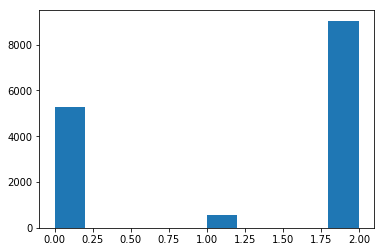

In [122]:
prediction = model.predict(test_data)
plt.hist(prediction)

In [123]:
def save_submission(predictions, test):
    data = {'id': test.index, 'status_group': predictions}

    submit = pd.DataFrame(data=data)

    vals_to_replace = {0:'non functional',
                       1:'functional needs repair',
                       2:'functional'}

    submit['status_group'] = submit['status_group'].replace(vals_to_replace)        

    submit.to_csv('pump_predictions.csv', index=False)

In [124]:
save_submission(prediction, test)